# Code Analysis

## Posture Descriptor Analysis

In [8]:
import spacy
import pandas as pd
import os
import re
import numpy as np

In [100]:
data_dir = "../data/mimic-iv/physionet.org/files/mimic-iv-note/2.2/note/"
data_file = "discharge.csv.gz"

data = pd.read_csv(os.path.join(data_dir, data_file))

In [101]:
posture_keyword = [
    r"\bposture\b",
]

In [102]:
pos_pattern = re.compile("|".join(positive_keywords), re.IGNORECASE)
exc_pattern = re.compile("|".join(exclude_keywords), re.IGNORECASE)

abnormal = data['text'].str.contains(pos_pattern, regex=True)
normal = data['text'].str.contains(exc_pattern, regex=True)
posture_notes = data[abnormal & ~normal]
print(posture_notes)
print(len(posture_notes))
posture_notes.to_csv("../output/posture_mention_notes.csv", index=False)

               note_id  subject_id   hadm_id note_type  note_seq  \
270      10006825-DS-8    10006825  29669544        DS         8   
399     10011938-DS-19    10011938  24772774        DS        19   
439     10013502-DS-20    10013502  20363238        DS        20   
535      10015487-DS-8    10015487  20588720        DS         8   
734      10022041-DS-3    10022041  28909879        DS         3   
...                ...         ...       ...       ...       ...   
330801  19968936-DS-12    19968936  20663275        DS        12   
331085  19978248-DS-30    19978248  28868652        DS        30   
331193   19981958-DS-8    19981958  21856502        DS         8   
331279  19985349-DS-10    19985349  20308632        DS        10   
331602  19994259-DS-21    19994259  21818613        DS        21   

                  charttime            storetime  \
270     2150-08-10 00:00:00  2150-08-10 22:56:00   
399     2132-01-30 00:00:00  2132-01-31 16:46:00   
439     2159-01-13 00:00:00

In [5]:
!uv run spacy download en_core_web_sm # need to run everytime because not persistent in nix environment


✘ No compatible package found for 'en_core_sci_sm' (spaCy v3.8.8)



In [48]:
import spacy
import pandas as pd
from sklearn.cluster import KMeans

nlp = spacy.load("en_core_web_sm")  # biomedical model

def extract_posture_descriptors(text):
    doc = nlp(text)
    descriptors = []
    for token in doc:
        if token.lemma_.lower() != "posture":
            continue
        # Find adjectives directly modifying 'posture'
        for child in token.children:
            if child.dep_ == "amod":
                # include left modifiers (advmod/compound)
                modifier_tokens = [t.text for t in child.lefts if t.dep_ in ("advmod", "compound")]
                modifier_tokens.append(child.text)
    
                # include negation or determiner if present
                for det in token.children:
                    if det.dep_ in ("det", "neg"):
                        modifier_tokens.insert(0, det.text)
    
                # join into phrase
                phrase = " ".join(modifier_tokens)
                descriptors.append(phrase)

    # deduplicate
    descriptors = list(dict.fromkeys(descriptors))

    return descriptors

No sentence-transformers model found with name emilyalsentzer/Bio_ClinicalBERT. Creating a new one with mean pooling.


In [103]:
data = pd.read_csv("../output/posture_mention_notes.csv")
print(data)

             note_id  subject_id   hadm_id note_type  note_seq  \
0      10006825-DS-8    10006825  29669544        DS         8   
1     10011938-DS-19    10011938  24772774        DS        19   
2     10013502-DS-20    10013502  20363238        DS        20   
3      10015487-DS-8    10015487  20588720        DS         8   
4      10022041-DS-3    10022041  28909879        DS         3   
...              ...         ...       ...       ...       ...   
1919  19968936-DS-12    19968936  20663275        DS        12   
1920  19978248-DS-30    19978248  28868652        DS        30   
1921   19981958-DS-8    19981958  21856502        DS         8   
1922  19985349-DS-10    19985349  20308632        DS        10   
1923  19994259-DS-21    19994259  21818613        DS        21   

                charttime            storetime  \
0     2150-08-10 00:00:00  2150-08-10 22:56:00   
1     2132-01-30 00:00:00  2132-01-31 16:46:00   
2     2159-01-13 00:00:00  2159-01-13 09:49:00   
3     2

In [104]:
descriptors = []
for idx, row in data.iterrows():
    descriptors.append(extract_posture_descriptors(row['text']))

In [105]:
data['posture_descriptors'] = descriptors

In [106]:
all_descriptors = [d for desc_list in data['posture_descriptors'] for d in desc_list]
descriptor_counts = pd.Series(all_descriptors).value_counts()
print(descriptor_counts.to_string())

normal                     102
good                        42
stooped                     31
upright                     26
well groomed                25
poor                        24
kyphotic                    20
flexed                      19
a flexed                    18
stated                      16
a stooped                   12
intermittent                12
Kyphotic                    12
fair                        11
grooming                     8
supine                       8
an upright                   8
rigid                        7
a forward                    7
tearful                      6
groomed                      6
hunched                      5
Slightly stooped             5
anxious                      5
seated                       5
intense                      5
contracted                   5
cooperative                  5
standing                     4
appropriate                  4
mild                         4
clean                        4
a more e

In [107]:
data.to_csv("../output/posture_mention_notes.csv", index=False) # save results

In [14]:
df = pd.read_csv("../output/posture_mention_notes.csv")
print(df)
all_descriptors = [d for desc_list in df['posture_descriptors'] for d in desc_list]
descriptor_counts = pd.Series(all_descriptors).value_counts()

             note_id  subject_id   hadm_id note_type  note_seq  \
0      10006825-DS-8    10006825  29669544        DS         8   
1     10011938-DS-19    10011938  24772774        DS        19   
2     10013502-DS-20    10013502  20363238        DS        20   
3      10015487-DS-8    10015487  20588720        DS         8   
4      10022041-DS-3    10022041  28909879        DS         3   
...              ...         ...       ...       ...       ...   
1919  19968936-DS-12    19968936  20663275        DS        12   
1920  19978248-DS-30    19978248  28868652        DS        30   
1921   19981958-DS-8    19981958  21856502        DS         8   
1922  19985349-DS-10    19985349  20308632        DS        10   
1923  19994259-DS-21    19994259  21818613        DS        21   

                charttime            storetime  \
0     2150-08-10 00:00:00  2150-08-10 22:56:00   
1     2132-01-30 00:00:00  2132-01-31 16:46:00   
2     2159-01-13 00:00:00  2159-01-13 09:49:00   
3     2

## Posture Description Assignment and Filtering

In [10]:
import pandas as pd
import re
import os

normal_posture_descriptors = [
    r'normal posture',
    r'good posture',
    r'upright posture',
    r"normal gait and posture",
    r"normal stance and posture",
    r"posture normal",
    r"good posture",
    r"appropriate posture",
    r"no postural abnormality",
    r"no abnormal posture"
]

abnormal_posture_descriptors = {
    "kyphotic": r'\bkyphotic\b',
    "stooped": r'\bstoop(?:ed)?\b',
    "hunched": r'\bhunch(?:ed)?\b',
    "flexed": r'flexed posture',
    "rigid": r'rigid posture',
    "contracted": r'contracted posture',
    "poor": r'poor posture',
}

severity_descriptors = [
    r"mild(?:ly)?",
    r"slight(?:ly)?",
    r"somewhat",
    r"fair(?:ly)?",
    r"severe(?:ly)?",
    r"very",
    r"exaggerated",
    r"intens(?:ly|e)?",
]

severity_patterns = [(re.compile(p, flags=re.I), p) for p in severity_descriptors]

# Precompile severity
severity_re = r"(" + "|".join(severity_descriptors) + r")"

# Precompile normal
normal_patterns = [re.compile(p, flags=re.I) for p in normal_posture_descriptors]


# ----- Main function -----

def find_posture_and_severity(text):
    text_l = text.lower()
    results = []

    # ---------- NORMAL POSTURE ----------
    for patt in normal_patterns:
        if patt.search(text_l):
            results.append({"type": "normal"})
            break  # only add once regardless of multiple matches

    # ---------- ABNORMAL POSTURE ----------
    for label, desc_pat in abnormal_posture_descriptors.items():

        # severity before descriptor
        combined = re.compile(rf"{severity_re}\s+{desc_pat}", re.I)
        simple = re.compile(desc_pat, re.I)

        # First: severity + descriptor
        for m in combined.finditer(text_l):
            severity = m.group(1)
            results.append({
                "type": "abnormal",
                "descriptor": label,
                "severity": severity
            })

        # If none with severity, add simple descriptor
        if not any(r.get("descriptor") == label for r in results):
            for m in simple.finditer(text_l):
                results.append({
                    "type": "abnormal",
                    "descriptor": label,
                    "severity": None
                })

    return results or None





In [5]:
data_dir = "../data/mimic-iv/physionet.org/files/mimic-iv-note/2.2/note/"
data_file = "discharge.csv.gz"

data = pd.read_csv(os.path.join(data_dir, data_file))

In [11]:
# Apply to DataFrame
data["posture_labels"] = data["text"].apply(find_posture_and_severity)


,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,text,posture_labels
0,10000032-DS-21,10000032,22595853,DS,21,2180-05-07 00:00:00,2180-05-09 15:26:00,\nName: ___ Unit No: _...,None
1,10000032-DS-22,10000032,22841357,DS,22,2180-06-27 00:00:00,2180-07-01 10:15:00,\nName: ___ Unit No: _...,None
2,10000032-DS-23,10000032,29079034,DS,23,2180-07-25 00:00:00,2180-07-25 21:42:00,\nName: ___ Unit No: _...,None
3,10000032-DS-24,10000032,25742920,DS,24,2180-08-07 00:00:00,2180-08-10 05:43:00,\nName: ___ Unit No: _...,None
4,10000084-DS-17,10000084,23052089,DS,17,2160-11-25 00:00:00,2160-11-25 15:09:00,\nName: ___ Unit No: __...,None
...,...,...,...,...,...,...,...,...,...
331788,19999828-DS-6,19999828,29734428,DS,6,2147-08-04 00:00:00,2147-08-12 15:36:00,\nName: ___ Unit No: ___...,None
331789,19999828-DS-7,19999828,25744818,DS,7,2149-01-18 00:00:00,2149-01-19 07:03:00,\nName: ___ Unit No: ___...,None
331790,19999840-DS-20,19999840,26071774,DS,20,2164-07-28 00:00:00,2164-07-29 14:52:00,\nName: ___ Unit No: ___\...,None
331791,19999840-DS-21,19999840,21033226,DS,21,2164-09-17 00:00:00,2164-09-18 01:36:00,\nName: ___ Unit No: ___\...,None


In [16]:
filtered_data = data[data['posture_labels'].notna()]
filtered_data.to_csv("../output/labeled_posture.csv", index=False)
filtered_data.to_pickle("../output/labeled_posture.pkl", index=False)

posture_data = filtered_data

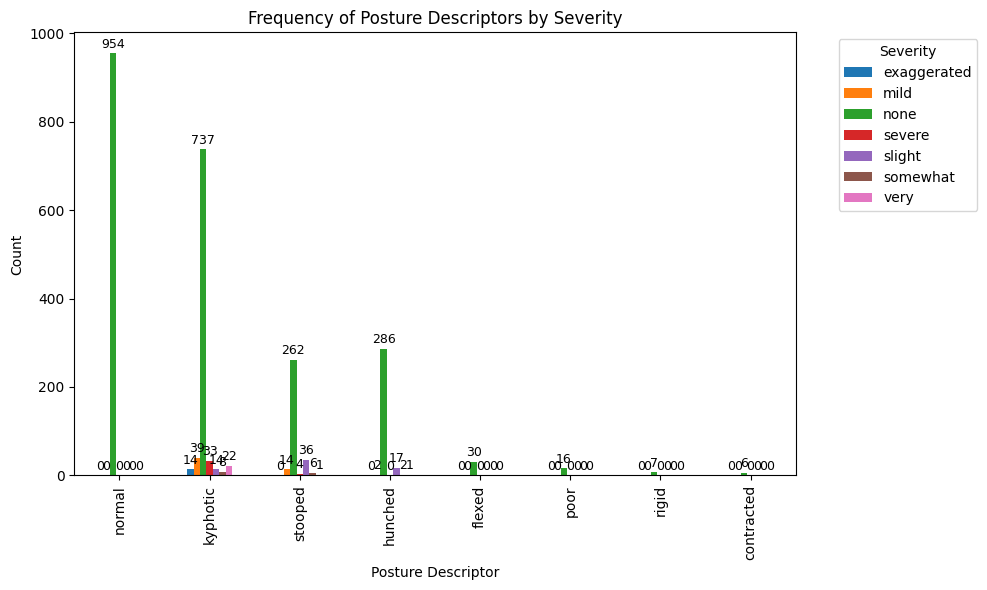

In [11]:
df = pd.read_pickle("../output/labeled_posture.pkl")
import matplotlib.pyplot as plt

records = []
# --- Flatten labels into a list of records ---
for labels in df["posture_labels"].dropna():
    for item in labels:
        if item["type"] == "abnormal":
            if item["severity"] and item['severity'].endswith("ly"):
                item['severity'] = item['severity'][:-2]
            records.append({
                "descriptor": item["descriptor"],
                "severity": item["severity"] if item["severity"] else "none"
            })
        elif item["type"] == "normal":
            records.append({
                "descriptor": "normal",
                "severity": "none"
            })

posture_flat = pd.DataFrame(records)

# --- Count occurrences ---
counts = posture_flat.value_counts(["descriptor", "severity"]).reset_index(name="count")

# --- Pivot for grouped bars ---
pivot = counts.pivot(index="descriptor", columns="severity", values="count").fillna(0)

# Optional: sort by total count
pivot = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).index]

# --- Build the summary DataFrame ---
posture_flat = pd.DataFrame(records)
counts = posture_flat.value_counts(["descriptor", "severity"]).reset_index(name="count")
pivot = counts.pivot(index="descriptor", columns="severity", values="count").fillna(0)
pivot = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).index]

# --- Plot the grouped bar chart ---
ax = pivot.plot(kind="bar", figsize=(10,6))
plt.title("Frequency of Posture Descriptors by Severity")
plt.xlabel("Posture Descriptor")
plt.ylabel("Count")
plt.legend(title="Severity", bbox_to_anchor=(1.05, 1), loc="upper left")

# --- Add count labels above each bar ---
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=9, padding=2)

plt.tight_layout()
plt.show()


## Assemble Preprocessed Data

In [274]:
import pandas as pd
import datetime
import os

data_dir = "../data/mimic-iv/physionet.org/files/mimiciv/3.1/hosp/"
posture_data = pd.read_pickle("../output/labeled_posture.pkl")
admissions_data = pd.read_csv(os.path.join(data_dir, "admissions.csv.gz"), parse_dates=['admittime', 'dischtime'])

posture_data_subjects_ids = posture_data['subject_id'].unique()
posture_data_hadm_ids = posture_data['hadm_id'].unique()

### Add hospital admit and discharge

In [275]:
posture_data = posture_data.merge(admissions_data[['subject_id', 'hadm_id', 'admittime', 'dischtime']],
    on=['subject_id', 'hadm_id'],
    how='left'  # keep all posture rows, even if admission not found
)
posture_data

,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,text,posture_labels,admittime,dischtime
0,10002930-DS-13,10002930,22733922,DS,13,2198-05-04 00:00:00,2198-05-04 19:18:00,\nName: ___ Unit No: ___\...,[{'type': 'normal'}],2198-04-22 16:17:00,2198-05-04 13:20:00
1,10005606-DS-17,10005606,29646384,DS,17,2143-12-16 00:00:00,2143-12-16 09:33:00,\nName: ___ ___ No: ___\n \nA...,"[{'type': 'abnormal', 'descriptor': 'kyphotic'...",2143-12-06 00:54:00,2143-12-16 16:00:00
2,10007920-DS-20,10007920,26693451,DS,20,2136-08-30 00:00:00,2136-09-05 12:44:00,\nName: ___. Unit No: ___\n \...,"[{'type': 'abnormal', 'descriptor': 'hunched',...",2136-08-27 17:14:00,2136-08-30 16:59:00
3,10015487-DS-9,10015487,23914645,DS,9,2172-09-22 00:00:00,2172-09-22 12:27:00,\nName: ___ Unit No: ___...,[{'type': 'normal'}],2172-08-29 09:51:00,2172-09-22 14:00:00
4,10026754-DS-3,10026754,22691839,DS,3,2136-08-18 00:00:00,2136-08-18 13:27:00,\nName: ___ Unit No: ___\...,[{'type': 'normal'}],2136-08-08 19:46:00,2136-08-18 14:54:00
...,...,...,...,...,...,...,...,...,...,...,...
2244,19965533-DS-9,19965533,25388109,DS,9,2188-02-05 00:00:00,2188-02-05 11:54:00,\nName: ___ Unit No: ...,"[{'type': 'abnormal', 'descriptor': 'hunched',...",2188-02-01 13:47:00,2188-02-05 12:35:00
2245,19968054-DS-19,19968054,27515437,DS,19,2174-12-17 00:00:00,2174-12-17 12:46:00,\nName: ___ Unit No: ___\n...,"[{'type': 'abnormal', 'descriptor': 'flexed', ...",2174-12-16 00:55:00,2174-12-17 14:50:00
2246,19985545-DS-22,19985545,28568303,DS,22,2144-02-06 00:00:00,2144-02-06 22:12:00,\nName: ___ Unit No: ...,[{'type': 'normal'}],2144-01-31 12:48:00,2144-02-06 11:45:00
2247,19985885-DS-9,19985885,25048461,DS,9,2176-08-23 00:00:00,2176-08-26 10:10:00,\nName: ___ Unit No: _...,"[{'type': 'abnormal', 'descriptor': 'kyphotic'...",2176-08-20 18:05:00,2176-08-23 13:30:00


### Compute Hospital Stay

In [276]:

time_format = '%Y-%m-%d %H:%M:%S'

def calc_hospital_stay_duration(admit_time_str, discharge_time_str):
    stay_duration = discharge_time_str - admit_time_str
    return stay_duration.days



In [277]:
posture_data['hospital_stay_duration'] = posture_data.apply(lambda x: calc_hospital_stay_duration(x['admittime'], x['dischtime']), axis=1)
posture_data

,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,text,posture_labels,admittime,dischtime,hospital_stay_duration
0,10002930-DS-13,10002930,22733922,DS,13,2198-05-04 00:00:00,2198-05-04 19:18:00,\nName: ___ Unit No: ___\...,[{'type': 'normal'}],2198-04-22 16:17:00,2198-05-04 13:20:00,11
1,10005606-DS-17,10005606,29646384,DS,17,2143-12-16 00:00:00,2143-12-16 09:33:00,\nName: ___ ___ No: ___\n \nA...,"[{'type': 'abnormal', 'descriptor': 'kyphotic'...",2143-12-06 00:54:00,2143-12-16 16:00:00,10
2,10007920-DS-20,10007920,26693451,DS,20,2136-08-30 00:00:00,2136-09-05 12:44:00,\nName: ___. Unit No: ___\n \...,"[{'type': 'abnormal', 'descriptor': 'hunched',...",2136-08-27 17:14:00,2136-08-30 16:59:00,2
3,10015487-DS-9,10015487,23914645,DS,9,2172-09-22 00:00:00,2172-09-22 12:27:00,\nName: ___ Unit No: ___...,[{'type': 'normal'}],2172-08-29 09:51:00,2172-09-22 14:00:00,24
4,10026754-DS-3,10026754,22691839,DS,3,2136-08-18 00:00:00,2136-08-18 13:27:00,\nName: ___ Unit No: ___\...,[{'type': 'normal'}],2136-08-08 19:46:00,2136-08-18 14:54:00,9
...,...,...,...,...,...,...,...,...,...,...,...,...
2244,19965533-DS-9,19965533,25388109,DS,9,2188-02-05 00:00:00,2188-02-05 11:54:00,\nName: ___ Unit No: ...,"[{'type': 'abnormal', 'descriptor': 'hunched',...",2188-02-01 13:47:00,2188-02-05 12:35:00,3
2245,19968054-DS-19,19968054,27515437,DS,19,2174-12-17 00:00:00,2174-12-17 12:46:00,\nName: ___ Unit No: ___\n...,"[{'type': 'abnormal', 'descriptor': 'flexed', ...",2174-12-16 00:55:00,2174-12-17 14:50:00,1
2246,19985545-DS-22,19985545,28568303,DS,22,2144-02-06 00:00:00,2144-02-06 22:12:00,\nName: ___ Unit No: ...,[{'type': 'normal'}],2144-01-31 12:48:00,2144-02-06 11:45:00,5
2247,19985885-DS-9,19985885,25048461,DS,9,2176-08-23 00:00:00,2176-08-26 10:10:00,\nName: ___ Unit No: _...,"[{'type': 'abnormal', 'descriptor': 'kyphotic'...",2176-08-20 18:05:00,2176-08-23 13:30:00,2


### Add Gender and Age Information

In [278]:
patient_data = pd.read_csv(os.path.join(data_dir, "patients.csv.gz"), parse_dates=['anchor_year', 'dod'])

print(patient_data[patient_data['subject_id'].isin(posture_data_subjects_ids)])

        subject_id gender  anchor_age anchor_year anchor_year_group        dod
119       10002930      F          48  2193-01-01       2011 - 2013 2201-12-24
214       10005606      M          38  2143-01-01       2017 - 2019        NaT
294       10007920      M          52  2132-01-01       2008 - 2010        NaT
578       10015487      M          47  2167-01-01       2008 - 2010        NaT
994       10026754      F          55  2133-01-01       2014 - 2016        NaT
...            ...    ...         ...         ...               ...        ...
363378    19965533      F          91  2188-01-01       2008 - 2010        NaT
363469    19968054      M          38  2174-01-01       2008 - 2010        NaT
364102    19985545      M          56  2135-01-01       2008 - 2010 2147-05-17
364114    19985885      F          91  2175-01-01       2008 - 2010 2181-02-05
364170    19987238      F          62  2163-01-01       2008 - 2010        NaT

[2044 rows x 6 columns]


In [279]:
def compute_age_from_anchor(admit_time_str, anchor_age, anchor_year):
    # admit_time = datetime.datetime.strptime(admit_time_str, time_format)
    # anchor_year_time = datetime.datetime(anchor_year, 1, 1)
    # anchor_age_time = datetime.datetime(anchor_age, 1, 1)
    true_age_yrs = admit_time_str - anchor_year
    return true_age_yrs.days // 365 + anchor_age

In [280]:
posture_data = posture_data.merge(patient_data[['subject_id', 'gender', 'anchor_age', 'anchor_year', 'dod']],
    on=['subject_id'],
    how='left'  # keep all posture rows, even if admission not found
)
posture_data

,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,text,posture_labels,admittime,dischtime,hospital_stay_duration,gender,anchor_age,anchor_year,dod
0,10002930-DS-13,10002930,22733922,DS,13,2198-05-04 00:00:00,2198-05-04 19:18:00,\nName: ___ Unit No: ___\...,[{'type': 'normal'}],2198-04-22 16:17:00,2198-05-04 13:20:00,11,F,48,2193-01-01,2201-12-24
1,10005606-DS-17,10005606,29646384,DS,17,2143-12-16 00:00:00,2143-12-16 09:33:00,\nName: ___ ___ No: ___\n \nA...,"[{'type': 'abnormal', 'descriptor': 'kyphotic'...",2143-12-06 00:54:00,2143-12-16 16:00:00,10,M,38,2143-01-01,NaT
2,10007920-DS-20,10007920,26693451,DS,20,2136-08-30 00:00:00,2136-09-05 12:44:00,\nName: ___. Unit No: ___\n \...,"[{'type': 'abnormal', 'descriptor': 'hunched',...",2136-08-27 17:14:00,2136-08-30 16:59:00,2,M,52,2132-01-01,NaT
3,10015487-DS-9,10015487,23914645,DS,9,2172-09-22 00:00:00,2172-09-22 12:27:00,\nName: ___ Unit No: ___...,[{'type': 'normal'}],2172-08-29 09:51:00,2172-09-22 14:00:00,24,M,47,2167-01-01,NaT
4,10026754-DS-3,10026754,22691839,DS,3,2136-08-18 00:00:00,2136-08-18 13:27:00,\nName: ___ Unit No: ___\...,[{'type': 'normal'}],2136-08-08 19:46:00,2136-08-18 14:54:00,9,F,55,2133-01-01,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2244,19965533-DS-9,19965533,25388109,DS,9,2188-02-05 00:00:00,2188-02-05 11:54:00,\nName: ___ Unit No: ...,"[{'type': 'abnormal', 'descriptor': 'hunched',...",2188-02-01 13:47:00,2188-02-05 12:35:00,3,F,91,2188-01-01,NaT
2245,19968054-DS-19,19968054,27515437,DS,19,2174-12-17 00:00:00,2174-12-17 12:46:00,\nName: ___ Unit No: ___\n...,"[{'type': 'abnormal', 'descriptor': 'flexed', ...",2174-12-16 00:55:00,2174-12-17 14:50:00,1,M,38,2174-01-01,NaT
2246,19985545-DS-22,19985545,28568303,DS,22,2144-02-06 00:00:00,2144-02-06 22:12:00,\nName: ___ Unit No: ...,[{'type': 'normal'}],2144-01-31 12:48:00,2144-02-06 11:45:00,5,M,56,2135-01-01,2147-05-17
2247,19985885-DS-9,19985885,25048461,DS,9,2176-08-23 00:00:00,2176-08-26 10:10:00,\nName: ___ Unit No: _...,"[{'type': 'abnormal', 'descriptor': 'kyphotic'...",2176-08-20 18:05:00,2176-08-23 13:30:00,2,F,91,2175-01-01,2181-02-05


In [281]:
posture_data['age'] = posture_data.apply(lambda x: compute_age_from_anchor(x['admittime'], x['anchor_age'], x['anchor_year']), axis=1)
posture_data

,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,text,posture_labels,admittime,dischtime,hospital_stay_duration,gender,anchor_age,anchor_year,dod,age
0,10002930-DS-13,10002930,22733922,DS,13,2198-05-04 00:00:00,2198-05-04 19:18:00,\nName: ___ Unit No: ___\...,[{'type': 'normal'}],2198-04-22 16:17:00,2198-05-04 13:20:00,11,F,48,2193-01-01,2201-12-24,53
1,10005606-DS-17,10005606,29646384,DS,17,2143-12-16 00:00:00,2143-12-16 09:33:00,\nName: ___ ___ No: ___\n \nA...,"[{'type': 'abnormal', 'descriptor': 'kyphotic'...",2143-12-06 00:54:00,2143-12-16 16:00:00,10,M,38,2143-01-01,NaT,38
2,10007920-DS-20,10007920,26693451,DS,20,2136-08-30 00:00:00,2136-09-05 12:44:00,\nName: ___. Unit No: ___\n \...,"[{'type': 'abnormal', 'descriptor': 'hunched',...",2136-08-27 17:14:00,2136-08-30 16:59:00,2,M,52,2132-01-01,NaT,56
3,10015487-DS-9,10015487,23914645,DS,9,2172-09-22 00:00:00,2172-09-22 12:27:00,\nName: ___ Unit No: ___...,[{'type': 'normal'}],2172-08-29 09:51:00,2172-09-22 14:00:00,24,M,47,2167-01-01,NaT,52
4,10026754-DS-3,10026754,22691839,DS,3,2136-08-18 00:00:00,2136-08-18 13:27:00,\nName: ___ Unit No: ___\...,[{'type': 'normal'}],2136-08-08 19:46:00,2136-08-18 14:54:00,9,F,55,2133-01-01,NaT,58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2244,19965533-DS-9,19965533,25388109,DS,9,2188-02-05 00:00:00,2188-02-05 11:54:00,\nName: ___ Unit No: ...,"[{'type': 'abnormal', 'descriptor': 'hunched',...",2188-02-01 13:47:00,2188-02-05 12:35:00,3,F,91,2188-01-01,NaT,91
2245,19968054-DS-19,19968054,27515437,DS,19,2174-12-17 00:00:00,2174-12-17 12:46:00,\nName: ___ Unit No: ___\n...,"[{'type': 'abnormal', 'descriptor': 'flexed', ...",2174-12-16 00:55:00,2174-12-17 14:50:00,1,M,38,2174-01-01,NaT,38
2246,19985545-DS-22,19985545,28568303,DS,22,2144-02-06 00:00:00,2144-02-06 22:12:00,\nName: ___ Unit No: ...,[{'type': 'normal'}],2144-01-31 12:48:00,2144-02-06 11:45:00,5,M,56,2135-01-01,2147-05-17,65
2247,19985885-DS-9,19985885,25048461,DS,9,2176-08-23 00:00:00,2176-08-26 10:10:00,\nName: ___ Unit No: _...,"[{'type': 'abnormal', 'descriptor': 'kyphotic'...",2176-08-20 18:05:00,2176-08-23 13:30:00,2,F,91,2175-01-01,2181-02-05,92


## Posture Dict to String

In [310]:
def compute_charlson_index(posture_dict_list):
    result = set()
    for posture_dict in posture_dict_list:
        if posture_dict['type'] == 'normal':
            posture_string = "normal"
        else:
            if posture_dict['severity']:
                if posture_dict['severity'].endswith("ly"):
                    severity = posture_dict['severity'][:-2]
                else:
                    severity = posture_dict['severity']
                posture_string = f"{severity} {posture_dict['descriptor']}"
            else:
                posture_string = posture_dict['descriptor']
        result.add(posture_string)
    return result
        

In [312]:
posture_data['posture_labels'] = posture_data['posture_labels'].apply(compute_charlson_index)

## Post Hospitalization Mortality

In [11]:
def compute_90_day_post_hospita_mort(discharge_date, dod):
    mortality_time = dod - discharge_date
    return mortality_time.days <= 90

In [21]:
posture_data['90_day_mort'] = posture_data.apply(lambda x: compute_90_day_post_hospita_mort(x['dischtime'], x['dod']), axis=1)
posture_data

,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,text,posture_labels,admittime,dischtime,hospital_stay_duration,gender,anchor_age,anchor_year,dod,age,bmi,90_day_mort
0,10002930-DS-13,10002930,22733922,DS,13,2198-05-04 00:00:00,2198-05-04 19:18:00,\nName: ___ Unit No: ___\...,{normal},2198-04-22 16:17:00,2198-05-04 13:20:00,11,F,48,2193-01-01,2201-12-24,53,NaN,False
1,10005606-DS-17,10005606,29646384,DS,17,2143-12-16 00:00:00,2143-12-16 09:33:00,\nName: ___ ___ No: ___\n \nA...,{kyphotic},2143-12-06 00:54:00,2143-12-16 16:00:00,10,M,38,2143-01-01,NaT,38,NaN,False
2,10007920-DS-20,10007920,26693451,DS,20,2136-08-30 00:00:00,2136-09-05 12:44:00,\nName: ___. Unit No: ___\n \...,{hunched},2136-08-27 17:14:00,2136-08-30 16:59:00,2,M,52,2132-01-01,NaT,56,NaN,False
3,10015487-DS-9,10015487,23914645,DS,9,2172-09-22 00:00:00,2172-09-22 12:27:00,\nName: ___ Unit No: ___...,{normal},2172-08-29 09:51:00,2172-09-22 14:00:00,24,M,47,2167-01-01,NaT,52,NaN,False
4,10026754-DS-3,10026754,22691839,DS,3,2136-08-18 00:00:00,2136-08-18 13:27:00,\nName: ___ Unit No: ___\...,{normal},2136-08-08 19:46:00,2136-08-18 14:54:00,9,F,55,2133-01-01,NaT,58,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2244,19965533-DS-9,19965533,25388109,DS,9,2188-02-05 00:00:00,2188-02-05 11:54:00,\nName: ___ Unit No: ...,{hunched},2188-02-01 13:47:00,2188-02-05 12:35:00,3,F,91,2188-01-01,NaT,91,NaN,False
2245,19968054-DS-19,19968054,27515437,DS,19,2174-12-17 00:00:00,2174-12-17 12:46:00,\nName: ___ Unit No: ___\n...,{flexed},2174-12-16 00:55:00,2174-12-17 14:50:00,1,M,38,2174-01-01,NaT,38,NaN,False
2246,19985545-DS-22,19985545,28568303,DS,22,2144-02-06 00:00:00,2144-02-06 22:12:00,\nName: ___ Unit No: ...,{normal},2144-01-31 12:48:00,2144-02-06 11:45:00,5,M,56,2135-01-01,2147-05-17,65,NaN,False
2247,19985885-DS-9,19985885,25048461,DS,9,2176-08-23 00:00:00,2176-08-26 10:10:00,\nName: ___ Unit No: _...,{kyphotic},2176-08-20 18:05:00,2176-08-23 13:30:00,2,F,91,2175-01-01,2181-02-05,92,NaN,False


## Export

In [22]:
posture_data.to_pickle("../output/posture_data_preprocessed.pkl")
export_data = posture_data[['subject_id', 'hadm_id', 'gender', 'age', 'posture_labels', 'hospital_stay_duration', '90_day_mort']]
export_data.to_csv("../output/posture_data_preprocessed_abridged.csv", index=False)